In [1]:
# 📦 Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('seaborn-v0_8')

# If using Google Colab, you can upload your CSV file directly
from google.colab import files
uploaded = files.upload()

# Read the uploaded CSV file into a DataFrame
# ⚠️ Replace 'your_file.csv' with the actual filename after upload
df = pd.read_csv('SalesData.csv', parse_dates=['Date'])

# ✅ Ensure your data is already cleaned and loaded
# e.g., df = pd.read_csv("your_data.csv", parse_dates=['Date'])

Saving SalesData.csv to SalesData.csv


In [2]:

# 📦 Step 2: Resample Time Series into Multiple Frequencies
df.set_index('Date', inplace=True)

weekly = df['Sum of Weekly_Sales'].resample('W').sum()
monthly = df['Sum of Weekly_Sales'].resample('M').sum()
quarterly = df['Sum of Weekly_Sales'].resample('Q').sum()
yearly = df['Sum of Weekly_Sales'].resample('Y').sum()



/tmp/ipython-input-2-2561615093.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df['Sum of Weekly_Sales'].resample('M').sum()
/tmp/ipython-input-2-2561615093.py:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly = df['Sum of Weekly_Sales'].resample('Q').sum()
/tmp/ipython-input-2-2561615093.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = df['Sum of Weekly_Sales'].resample('Y').sum()


In [3]:
# 📦 Step 3: Define Forecasting Function with Moving Average and MAPE
def improved_forecast(series, title, steps, seasonal_period, freq):
    print(f"\n📈 Forecasting: {title} ({steps} steps, {freq} frequency)")

    # Handle seasonal_period = 0 safely
    if seasonal_period == 0:
        model = SARIMAX(series,
                        order=(1, 1, 1),
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        print(f"Note: No seasonal component included for {title}.")
    else:
        model = SARIMAX(series,
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, seasonal_period),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

    results = model.fit(disp=False)

    # Forecast
    forecast_results = results.get_forecast(steps=steps)
    forecast = forecast_results.predicted_mean
    conf_int = forecast_results.conf_int()

    forecast_index = pd.date_range(start=series.index[-1] + pd.tseries.frequencies.to_offset(freq),
                                   periods=steps, freq=freq)

    # Static plot
    plt.figure(figsize=(12, 5))
    plt.plot(series, label='Historical')

    # Add Moving Average line
    moving_avg = series.rolling(window=4).mean()
    plt.plot(moving_avg, label='4-Period Moving Average', linestyle='--', color='green')

    plt.plot(forecast_index, forecast, label=f'{steps}-Step Forecast', linestyle='--', color='red')
    plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                     color='pink', alpha=0.3, label='95% Confidence Interval')
    plt.title(f"{title} - Forecast for {steps} Steps")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Interactive plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=series.index, y=series.values, name='Historical'))
    fig.add_trace(go.Scatter(x=series.index, y=moving_avg.values, name='Moving Average',
                             line=dict(dash='dot', color='green')))
    fig.add_trace(go.Scatter(x=forecast_index, y=forecast.values, name='Forecast', line=dict(dash='dash')))
    fig.add_trace(go.Scatter(x=forecast_index, y=conf_int.iloc[:, 0], name='Lower Bound',
                             line=dict(color='lightpink'), showlegend=False))
    fig.add_trace(go.Scatter(x=forecast_index, y=conf_int.iloc[:, 1], name='Upper Bound',
                             line=dict(color='lightpink'), fill='tonexty', showlegend=False))
    fig.update_layout(title=f"Interactive Forecast: {title}",
                      xaxis_title="Date", yaxis_title="Sales")
    fig.show()

    # Seasonal decomposition
    if seasonal_period > 1:
        decomposition = seasonal_decompose(series, model='additive', period=seasonal_period)
        decomposition.plot()
        plt.suptitle(f"Seasonal Decomposition: {title}", fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping seasonal decomposition for {title} (no valid seasonal period).")

    # Residual analysis
    residuals = results.resid
    plt.figure(figsize=(10, 4))
    sns.histplot(residuals.dropna(), kde=True)
    plt.title(f"Residual Distribution: {title}")
    plt.xlabel("Residuals")
    plt.show()

    # ACF of residuals
    lags_to_plot = min(len(residuals.dropna()) - 1, 20) if len(residuals.dropna()) > 1 else None
    if lags_to_plot is not None:
        plot_acf(residuals.dropna(), lags=lags_to_plot)
        plt.title(f"ACF of Residuals: {title}")
        plt.show()
    else:
        print(f"Not enough data to plot ACF for {title} residuals.")

    # Error metrics
    if len(series) > len(results.fittedvalues):
        trimmed_series = series[-len(results.fittedvalues):]
    else:
        trimmed_series = series

    rmse = np.sqrt(mean_squared_error(trimmed_series, results.fittedvalues[:len(trimmed_series)]))
    mae = mean_absolute_error(trimmed_series, results.fittedvalues[:len(trimmed_series)])
    mape = np.mean(np.abs((trimmed_series - results.fittedvalues[:len(trimmed_series)]) / trimmed_series)) * 100

    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Return forecast dataframe
    return pd.DataFrame({'Date': forecast_index, 'Forecast': forecast.values})


📈 Forecasting: Weekly Sales (156 steps, W frequency)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


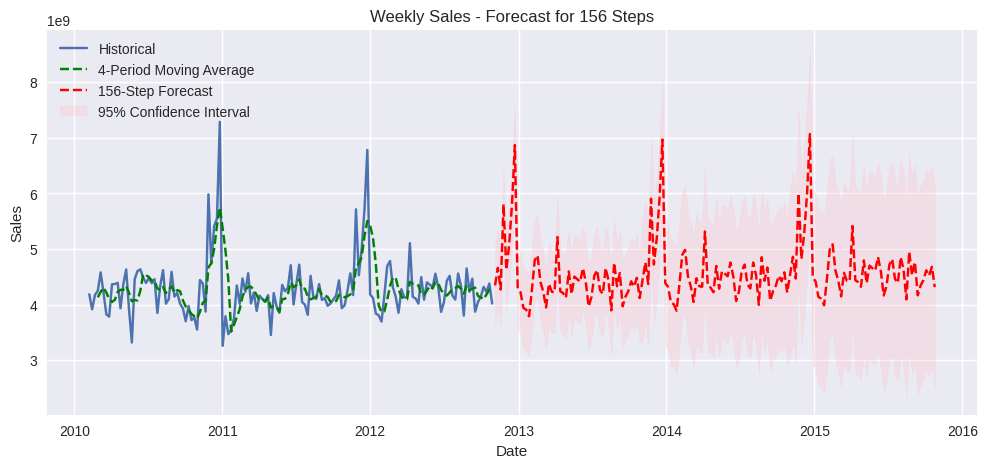

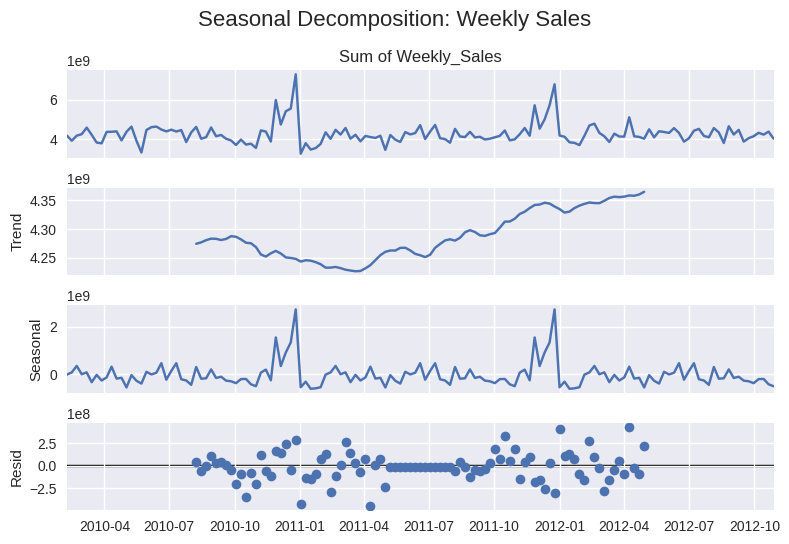

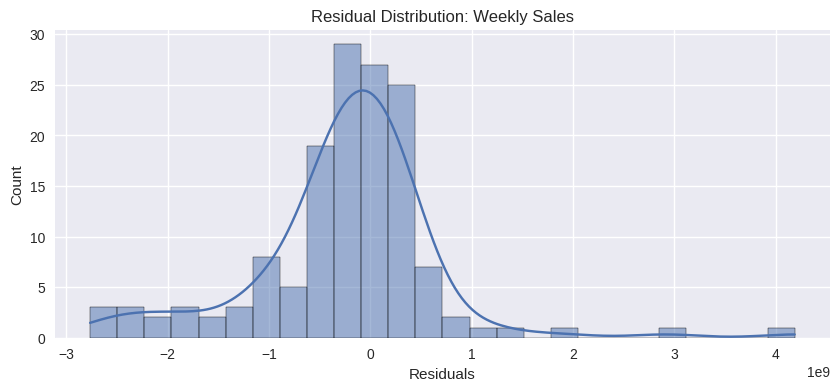

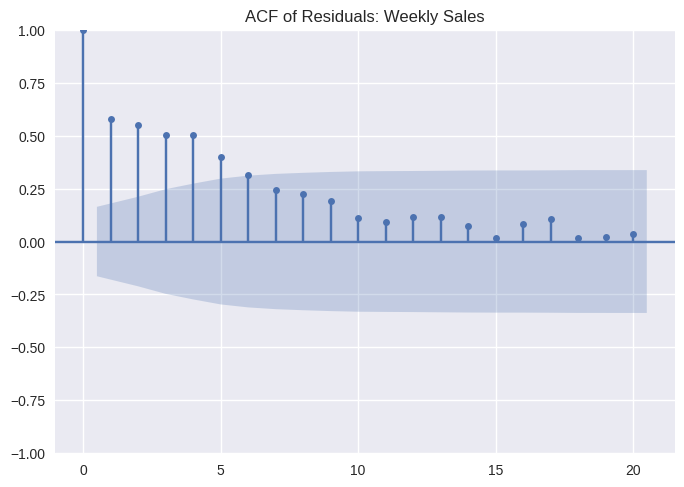

RMSE: 926584484.23
MAE: 597589976.61
MAPE: 14.03%

📈 Forecasting: Monthly Sales (36 steps, M frequency)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/tmp/ipython-input-3-4095669652.py:27: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



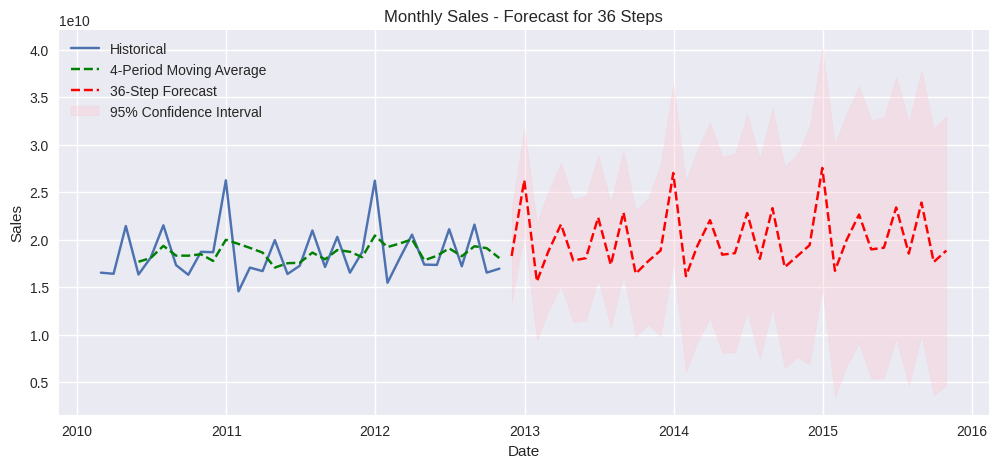

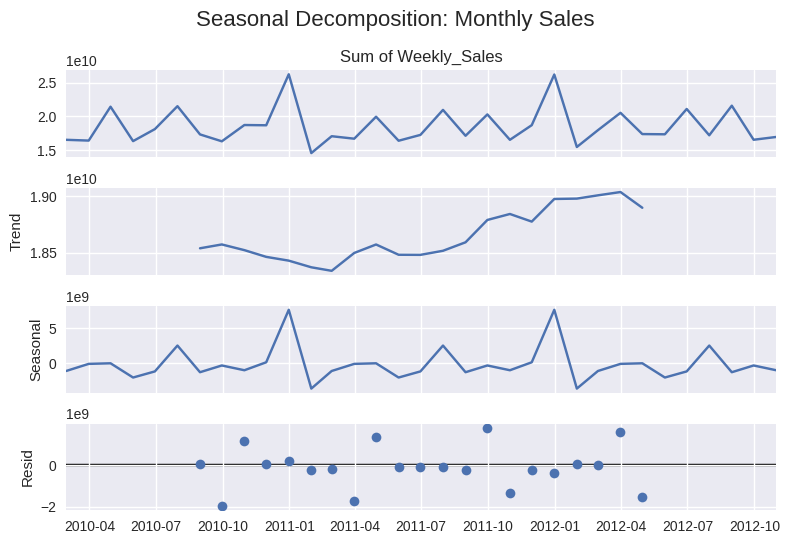

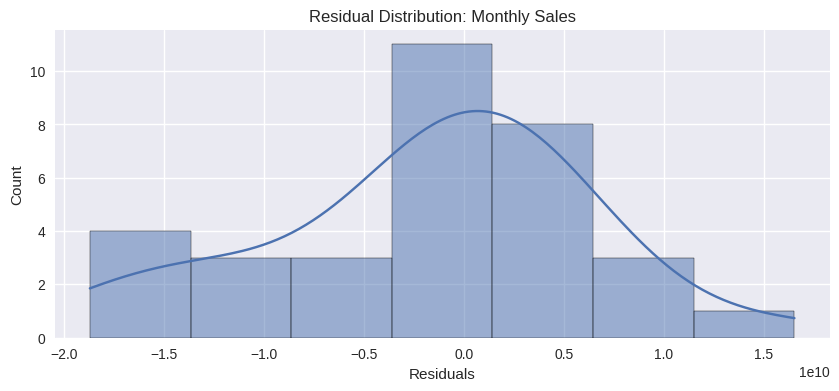

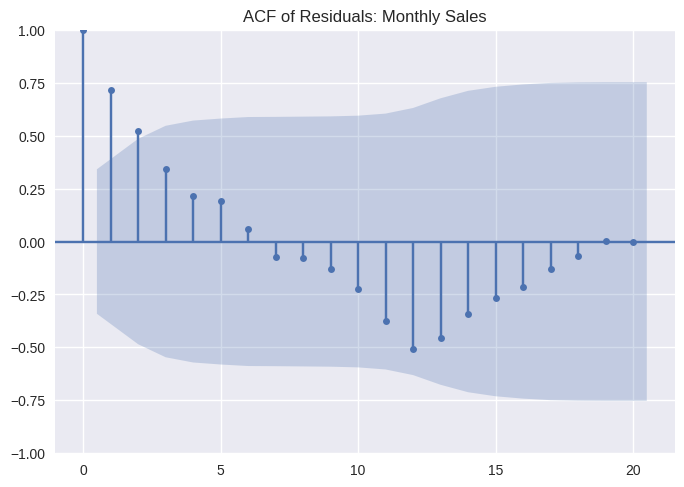

RMSE: 8169629945.18
MAE: 6155814488.80
MAPE: 33.62%

📈 Forecasting: Quarterly Sales (12 steps, Q frequency)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/tmp/ipython-input-3-4095669652.py:27: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



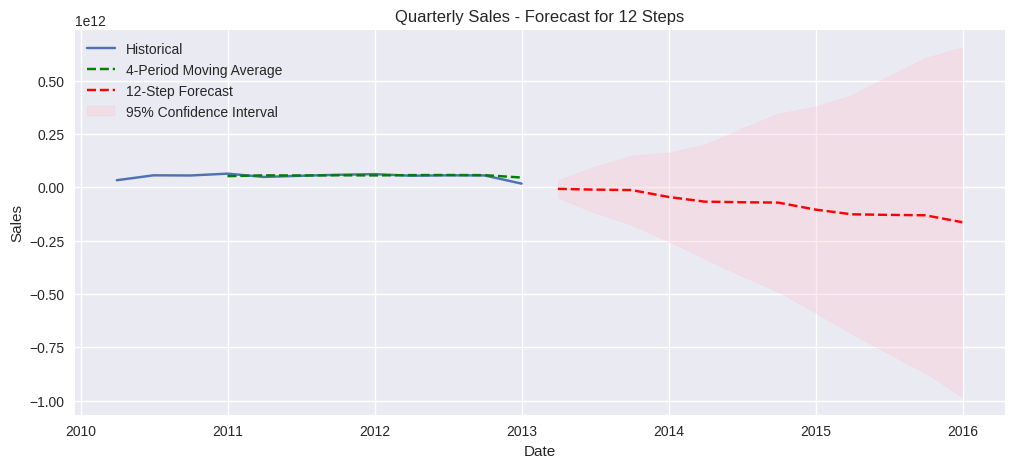

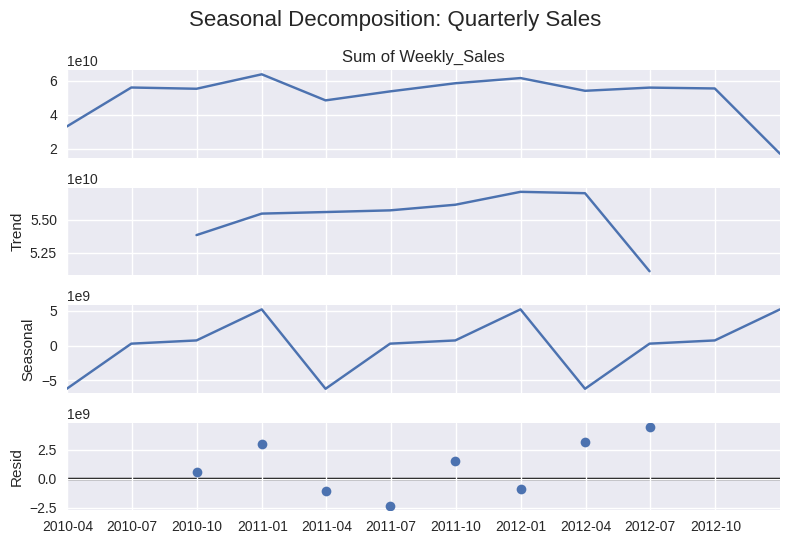

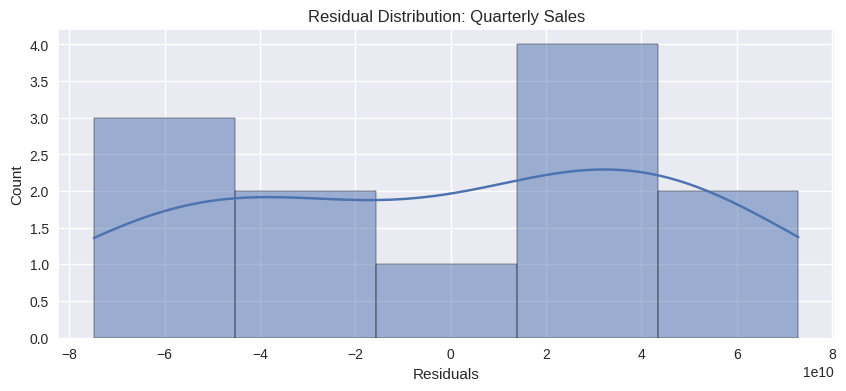

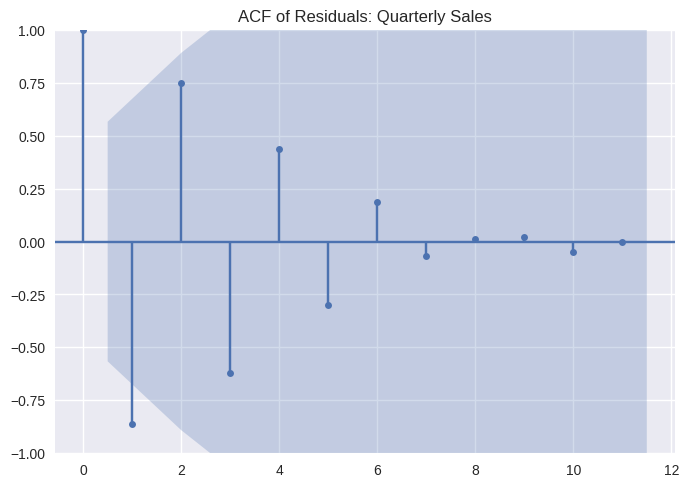

RMSE: 47050212268.66
MAE: 42236414392.83
MAPE: 79.84%

📈 Forecasting: Yearly Sales (3 steps, Y frequency)
Note: No seasonal component included for Yearly Sales.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1235: RuntimeWarning:

invalid value encountered in divide

/tmp/ipython-input-3-4095669652.py:27: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



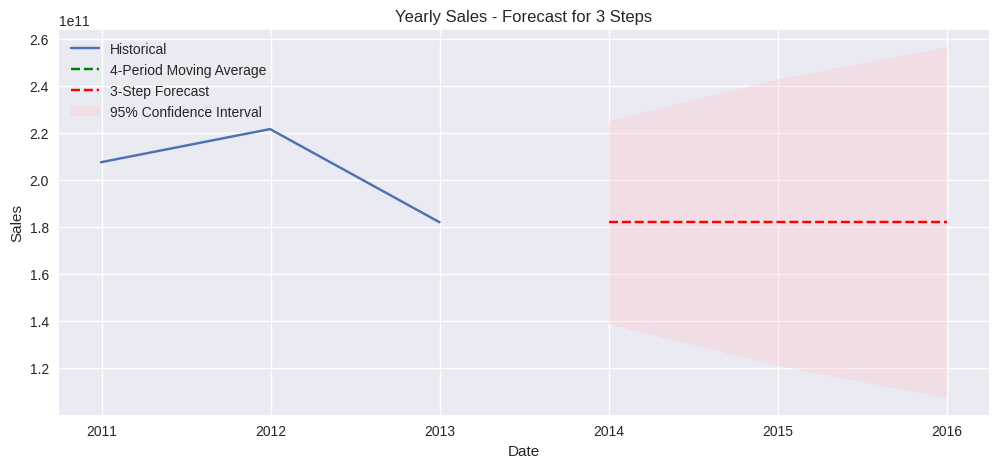

Skipping seasonal decomposition for Yearly Sales (no valid seasonal period).


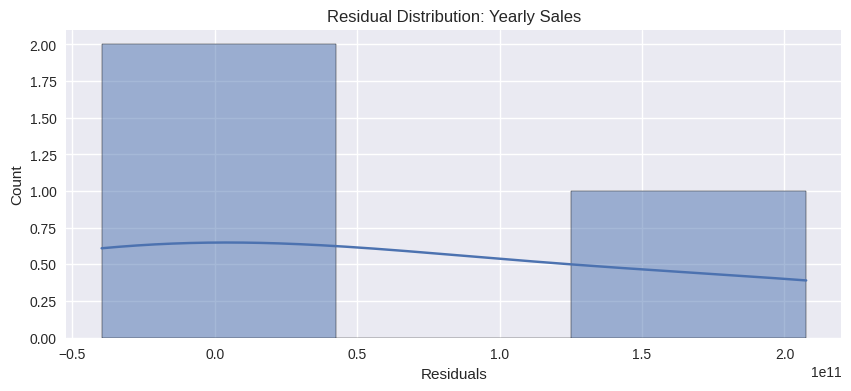

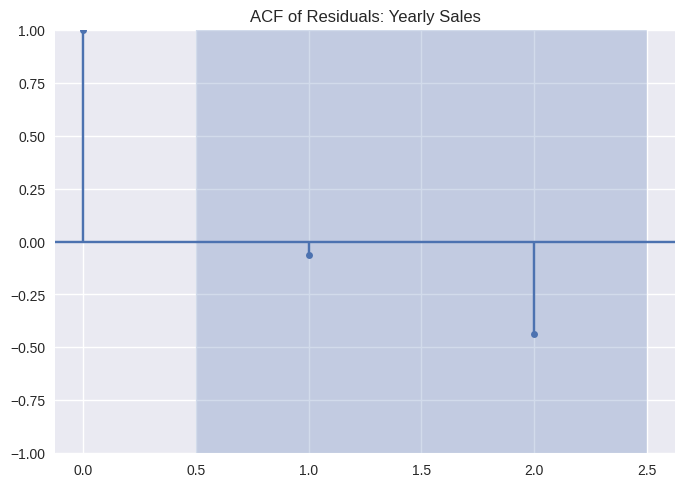

RMSE: 122316735496.90
MAE: 87143819734.67
MAPE: 42.72%


In [4]:
# 📦 Step 4: Apply Forecast Function for All Frequencies (3-Year Horizons)
weekly_forecast_df = improved_forecast(weekly, "Weekly Sales", steps=156, seasonal_period=52, freq='W')
monthly_forecast_df = improved_forecast(monthly, "Monthly Sales", steps=36, seasonal_period=12, freq='M')
quarterly_forecast_df = improved_forecast(quarterly, "Quarterly Sales", steps=12, seasonal_period=4, freq='Q')
yearly_forecast_df = improved_forecast(yearly, "Yearly Sales", steps=3, seasonal_period=0, freq='Y')

In [5]:
# 📦 Step 5: Export Forecasts and Visuals if Needed
weekly_forecast_df.to_csv('weekly_forecast.csv', index=False)
monthly_forecast_df.to_csv('monthly_forecast.csv', index=False)
quarterly_forecast_df.to_csv('quarterly_forecast.csv', index=False)
yearly_forecast_df.to_csv('yearly_forecast.csv', index=False)

# Save visual assets (optional)
import os
from google.colab import files
import matplotlib.pyplot as plt
import plotly.io as pio

# Create folder to hold plots
os.makedirs("forecast_visuals", exist_ok=True)

# Re-generate and save visuals explicitly for each forecast
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

def save_all_visuals(series, forecast_df, conf_int, residuals, title, freq, seasonal_period):
    forecast_index = forecast_df['Date']
    forecast = forecast_df['Forecast']

    # Static Forecast Plot
    plt.figure(figsize=(12, 5))
    plt.plot(series, label='Historical')
    plt.plot(forecast_index, forecast, label='Forecast', linestyle='--', color='red')
    plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f"{title} - Forecast")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"forecast_visuals/{title.replace(' ', '_').lower()}_forecast.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Residual Histogram
    plt.figure(figsize=(10, 4))
    sns.histplot(residuals.dropna(), kde=True)
    plt.title(f"Residual Distribution: {title}")
    plt.savefig(f"forecast_visuals/{title.replace(' ', '_').lower()}_residuals.png", dpi=300, bbox_inches='tight')
    plt.close()

    # ACF Plot
    plt.figure(figsize=(8, 4))
    plot_acf(residuals.dropna(), lags=20)
    plt.title(f"ACF of Residuals: {title}")
    plt.savefig(f"forecast_visuals/{title.replace(' ', '_').lower()}_acf.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Seasonal Decomposition
    decomposition = seasonal_decompose(series, model='additive', period=seasonal_period)
    fig = decomposition.plot()
    fig.suptitle(f"Seasonal Decomposition: {title}", fontsize=16)
    fig.tight_layout()
    fig.savefig(f"forecast_visuals/{title.replace(' ', '_').lower()}_decomposition.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Interactive Forecast
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=series.index, y=series.values, name='Historical'))
    fig.add_trace(go.Scatter(x=forecast_index, y=forecast, name='Forecast', line=dict(dash='dash')))
    fig.add_trace(go.Scatter(x=forecast_index, y=conf_int.iloc[:, 0], name='Lower Bound', line=dict(color='lightpink'), showlegend=False))
    fig.add_trace(go.Scatter(x=forecast_index, y=conf_int.iloc[:, 1], name='Upper Bound', line=dict(color='lightpink'), fill='tonexty', showlegend=False))
    fig.update_layout(title=f"Interactive Forecast: {title}", xaxis_title="Date", yaxis_title="Sales")
    fig.write_html(f"forecast_visuals/{title.replace(' ', '_').lower()}_interactive.html")
# For now, only HTML plots will be saved automatically from inside the function

# Zip and download
!zip -r forecast_visuals.zip forecast_visuals/
files.download("forecast_visuals.zip")
files.download("weekly_forecast.csv")
files.download("monthly_forecast.csv")
files.download("quarterly_forecast.csv")
files.download("yearly_forecast.csv")

print("✅ Forecasts and visuals saved and ready for download.")




  adding: forecast_visuals/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Forecasts and visuals saved and ready for download.


In [6]:
import shutil
from google.colab import files

# Compress the folder into a zip file
shutil.make_archive("forecast_visuals", 'zip', "forecast_visuals")

# Download the zip file
files.download("forecast_visuals.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>